In [1]:
# %load main.py
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

from armax import armax
from config import config
import mysql_utils as mysql
import visualization

In [2]:
DATA_FREQUENCY = dt.timedelta(minutes=5)

In [3]:
intersection = pd.read_csv("data/intersection_608_flow_original.csv", index_col=0, parse_dates=True)

In [3]:
#DETECTOR_DATA_TABLE = "detector_data_processed_2017_1"
DETECTOR_DATA_TABLE = "detector_data_processed_2017"
INTERSECTION = [608217, 608219, 608103, 608102, 608106, 608114, 608108]
QUERY = "WITH intersection AS (SELECT Year, Month, Day, Time, Volume AS Flow, DetectorID \
FROM {} NATURAL JOIN detector_health WHERE ({}) AND Health = 1) \
SELECT Year, Month, Day, Time, {} FROM intersection GROUP BY Year, Month, Day, Time ORDER BY Year, Month, Day, Time;"\
.format(DETECTOR_DATA_TABLE, " OR ".join(["DetectorId = {}".format(detector_id) for detector_id in INTERSECTION]),
        ", ".join(["SUM(IF (DetectorId = {}, Flow, NULL))".format(detector_id) for detector_id in INTERSECTION]))

In [4]:
def query_detector_data(cursor):
    query = QUERY

    cursor = mysql.query(cursor, query)
    
    if cursor == None:
        return
    
    lists = []

    for row in cursor:
        r = [dt.datetime(row[0], row[1], row[2], row[3] // 3600, (row[3] % 3600) // 60, row[3] % 60)]
        r.extend(row[4:])
        lists.append(r)
    
    df = pd.DataFrame(lists, columns=['Date'] + [str(detector) for detector in INTERSECTION]).set_index('Date')

    return df

In [5]:
cnx = mysql.connect_to_database(**config)

if cnx == None:
    sys.exit()

cursor = cnx.cursor()

In [6]:
intersection = query_detector_data(cursor)

In [7]:
intersection.shape

(102816, 7)

In [8]:
intersection.columns

Index(['608217', '608219', '608103', '608102', '608106', '608114', '608108'], dtype='object')

In [12]:
intersection.isnull().sum().sum()

34848

In [45]:
exit = intersection['608217'] + intersection['608219']
left = intersection['608103']
straight_left = intersection['608114']
straight_straight = intersection['608102'] + intersection['608106']
straight = straight_straight - straight_left
right = intersection['608108']
total = left + straight + right

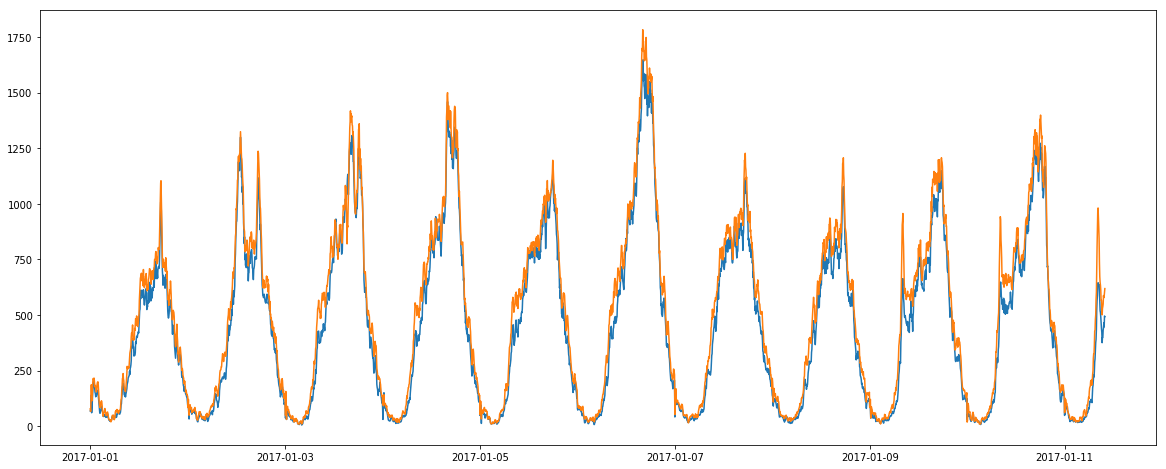

In [46]:
plt.figure(figsize=(20, 8))
plt.plot(exit[:3000])
# plt.plot(left[:3000])
# plt.plot(straight_straight[:3000])
# plt.plot(straight[:3000])
# plt.plot(right[:3000])
plt.plot(total[:3000])
plt.show()

In [7]:
cursor.close()
cnx.close()